In [1]:
# pip install numpy pandas scikit-learn joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# 1) Load your features + labels
df = pd.read_csv("librossa_features_2.csv")      # columns: feat1,feat2,...,emotion
X = df.drop("emotion", axis=1).values
y = df["emotion"].values

# 2) Split (optional hold-out)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=1
)


In [ ]:

class InfoGainSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.045, random_state=42):
        self.threshold = threshold
        self.random_state = random_state

    def fit(self, X, y):
        # compute “info gain” scores per feature
        self.scores_ = mutual_info_classif(X, y, random_state=self.random_state)
        # build a boolean mask of features to keep
        self.mask_ = self.scores_ >= self.threshold
        if not np.any(self.mask_):
            raise ValueError(
                f"No features passed the threshold={self.threshold}"
            )
        return self

    def transform(self, X):
        # slice columns
        return X[:, self.mask_]

    def get_support(self):
        return self.mask_

    def get_feature_scores(self):
        return self.scores_

# 3) Define base learners with roughly the same hyperparameters
mlp = MLPClassifier(
    hidden_layer_sizes=(len(df.columns)-1,),  # “t” hidden units in Weka = #attributes
    learning_rate_init=0.03,   # -L 0.03
    momentum=0.2,              # -M 0.2
    max_iter=500,              # -N 500
    tol=1e-4,                  # stopping tolerance
    random_state=0,
)

rf_plain = RandomForestClassifier(
    n_estimators=100,          # -I 100
    min_samples_leaf=1,        # -M 1.0 (no min)
    random_state=1,
    n_jobs=1
)

# Weka’s MultiClassClassifier wraps RF for true multiclass; in sklearn:
rf_ovr = OneVsRestClassifier(
    RandomForestClassifier(
        n_estimators=100,
        random_state=1
    ),
    n_jobs=1
)

# 4) Meta-learner: LogisticRegression with a tiny ridge (-R 1e-8 => C=1e8)
meta = LogisticRegression(
    C=1e8,
    solver="lbfgs",
    class_weight={0:1, 1:5, 2:11}, 
    max_iter=1000,
    multi_class="ovr",
    random_state=1
)

# 5) Build the stacking pipeline
stack = StackingClassifier(
    estimators=[
        ("mlp", mlp),
        ("rf_ovr", rf_ovr),
        ("rf", rf_plain),
    ],
    final_estimator=meta,
    cv=3,            # internal folds for generating meta-features
    n_jobs=1,        # -num-slots 1
    passthrough=False
)

pipeline = make_pipeline(
    SMOTE(sampling_strategy="auto", random_state=42, k_neighbors=5),  # oversample the minority class
    InfoGainSelector(threshold=0.045, random_state=42),  # select features
    StandardScaler(),  # scale everything up front
    stack,
)


              precision    recall  f1-score   support

    negative       0.91      0.85      0.88       263
     neutral       0.83      0.85      0.84        97
    positive       0.64      0.78      0.70        65

    accuracy                           0.84       425
   macro avg       0.79      0.83      0.81       425
weighted avg       0.85      0.84      0.84       425



c:\Users\jbkee\Desktop\Jupyter-Projects\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


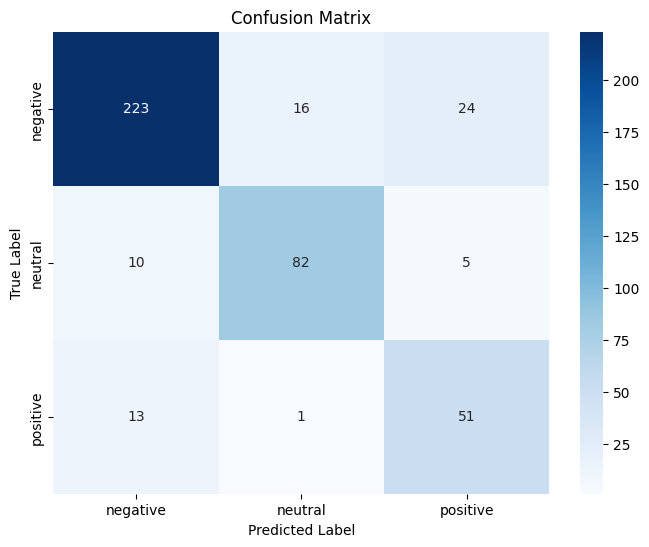

['ser_stacking.pkl']

In [ ]:
# 7) Train on all train data & evaluate on test
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=["negative","neutral","positive"],
    yticklabels=["negative","neutral","positive"]
    )
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 8) Save for later
import joblib
joblib.dump(pipeline, "ser_stacking.pkl")


In [24]:
mask = pipeline.steps[1][1].get_support()
feature_names = df.columns[:-1][mask]
print(feature_names.values, "=>", len(feature_names.values), "features selected")

['mfcc_1_mean' 'mfcc_1_median' 'mfcc_1_std_dev' 'mfcc_1_min' 'mfcc_1_max'
 'mfcc_1_q1' 'mfcc_1_iqr' 'mfcc_1_jitter' 'mfcc_1_shimmer'
 'mfcc_1_skewness' 'mfcc_1_kurtosis' 'mfcc_1_peak_count' 'mfcc_1_range'
 'mfcc_1_delta_mean' 'mfcc_1_delta_std_dev' 'mfcc_1_delta_min'
 'mfcc_1_delta_iqr' 'mfcc_1_delta_jitter' 'mfcc_1_delta_shimmer'
 'mfcc_1_delta_skewness' 'mfcc_1_delta_peak_count' 'mfcc_1_delta_range'
 'mfcc_1_delta2_mean' 'mfcc_1_delta2_median' 'mfcc_1_delta2_min'
 'mfcc_1_delta2_q3' 'mfcc_1_delta2_shimmer' 'mfcc_1_delta2_kurtosis'
 'mfcc_1_delta2_peak_count' 'mfcc_2_mean' 'mfcc_2_median' 'mfcc_2_std_dev'
 'mfcc_2_min' 'mfcc_2_max' 'mfcc_2_q1' 'mfcc_2_q3' 'mfcc_2_iqr'
 'mfcc_2_jitter' 'mfcc_2_shimmer' 'mfcc_2_skewness' 'mfcc_2_peak_count'
 'mfcc_2_range' 'mfcc_2_delta_mean' 'mfcc_2_delta_std_dev'
 'mfcc_2_delta_min' 'mfcc_2_delta_max' 'mfcc_2_delta_q1'
 'mfcc_2_delta_jitter' 'mfcc_2_delta_shimmer' 'mfcc_2_delta_peak_count'
 'mfcc_2_delta_range' 'mfcc_2_delta2_mean' 'mfcc_2_delta2_std_